# NLP (procesamiento de lenguaje natural) con Python

¡Este es el notebook que estaremos viendo como aplicar NLP!

En esta ocasión discutiremos una descripción general de nivel superior de los conceptos básicos del procesamiento del lenguaje natural, que básicamente consiste en combinar técnicas de aprendizaje automático con texto y usar matemáticas y estadísticas para obtener ese texto en un formato que los algoritmos de aprendizaje automático puedan entender.

Una vez que haya completado esta lección, tendrá un proyecto que utiliza algunos datos de texto de Yelp.

In [1]:
# Primero debemos correr los códigos siguientes para instalar la librería NLTK 

#conda install nltk 

## Obtención de datos

Usaremos un conjunto de datos de los [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). Este conjunto de datos ya se encuentra en la carpeta de esta sección.

El archivo que estamos usando contiene una colección de más de 5 mil mensajes telefónicos SMS. 


In [2]:
import pandas as pd

In [3]:
messages = pd.read_excel('sms.xlsx')
messages.head()

,label,mensaje
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Análisis Exploratorio de Datos

¡Veamos algunas de las estadísticas con algunos gráficos y los métodos incorporados en pandas!

In [4]:
messages.describe()

,label,mensaje
count,5571,5571
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4824,30


Usemos **groupby** para usar describe por etiqueta, de esta manera podemos comenzar a pensar en las características que separan el ham y el spam.

In [5]:
messages.groupby('label').describe()

mensaje                                                               
        count unique                                                top freq
label                                                                       
ham      4824   4515                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

A medida que continuamos con nuestro análisis, queremos empezar a pensar en las funciones que vamos a utilizar. Esto va de la mano con la idea general de [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). Cuanto mejor sea su conocimiento de dominio sobre los datos, mejor será su capacidad para diseñar más funciones a partir de ellos. La ingeniería de variables es una parte muy importante de la detección de spam en general. ¡Te animo a leer sobre el tema!

Hagamos una nueva columna para detectar el largo de los mensajes de texto:

In [6]:
messages['length'] = messages['mensaje'].str.len()
messages.head()

,label,mensaje,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Visualizaciones
Vamos a graficar.. importar librerías primero..

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

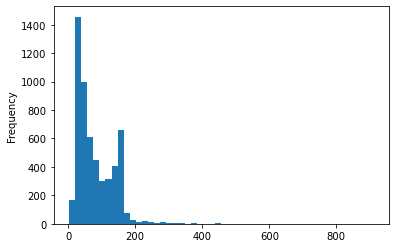

In [8]:
messages['length'].plot(bins=50, kind='hist') 

¡Juega con el tamaño de los bins! ¡Parece que la longitud del texto puede ser una buena característica en la que pensar! Intentemos explicar por qué el eje x llega hasta casi 1000, ¡esto debe significar que hay un mensaje realmente largo!

In [9]:
messages.length.describe()

count    5571.000000
mean       80.503859
std        59.939294
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

¡Woah! 910 caracteres, usemos filtrado para encontrar este mensaje:

In [10]:
messages[messages['length'] == 910]['mensaje'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

¡Parece que tenemos una especie de Romeo enviando mensajes de texto! Pero volvamos a centrarnos en la idea de tratar de ver si la longitud del mensaje es una característica distintiva entre ham y spam:

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

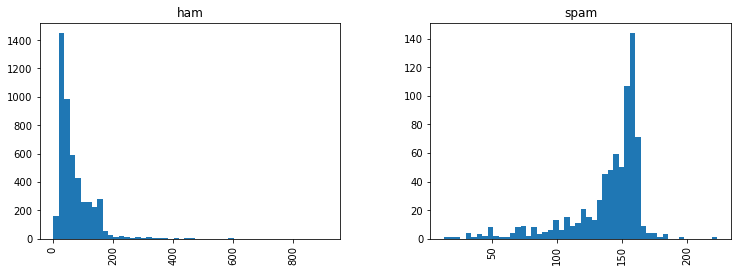

In [11]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

¡Muy interesante! A través de la EDA básica, hemos podido descubrir una tendencia según la cual los mensajes de spam tienden a tener más caracteres. (¡Lo siento Romeo!)

¡Ahora comencemos a procesar los datos para que eventualmente podamos usarlos con SciKit Learn!

## Pre-procesamiento de texto

Nuestro principal problema con nuestros datos es que están todos en formato de texto (cadenas). Los algoritmos de clasificación que hemos aprendido hasta ahora necesitarán algún tipo de vector de características numéricas para realizar la tarea de clasificación. En realidad, existen muchos métodos para convertir un corpus a formato vectorial. El más simple es el enfoque de [bolsa-de-palabras](http://en.wikipedia.org/wiki/Bag-of-words_model), donde cada palabra única en un texto estará representada por un número.


En esta sección convertiremos los mensajes sin formato (secuencia de caracteres) en vectores (secuencias de números).

Como primer paso, escribamos una función que dividirá un mensaje en sus palabras individuales y devolverá una lista. También eliminaremos palabras muy comunes, ('de', 'el', etc.). Para ello aprovecharemos la biblioteca NLTK. Es prácticamente la biblioteca estándar en Python para procesar texto y tiene muchas características útiles. Aquí solo usaremos algunos de los básicos.

Creemos una función que procese la cadena en la columna del mensaje, luego podemos usar **apply()** para que los pandas procesen todo el texto en el DataFrame.

Primero eliminando la puntuación. Podemos aprovechar la biblioteca **string** incorporada de Python para obtener una lista rápida de toda la puntuación posible:

In [12]:
import string
#puntuaciones en string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
mess = 'Sample message! Notice: it has punctuation.'

# verifica si algun caracter (letra o numero o simbolo) es una puntuacion y no la toma del texto
nopunc = [char for char in mess if char not in string.punctuation]



In [14]:
nopunc

['S',
 'a',
 'm',
 'p',
 'l',
 'e',
 ' ',
 'm',
 'e',
 's',
 's',
 'a',
 'g',
 'e',
 ' ',
 'N',
 'o',
 't',
 'i',
 'c',
 'e',
 ' ',
 'i',
 't',
 ' ',
 'h',
 'a',
 's',
 ' ',
 'p',
 'u',
 'n',
 'c',
 't',
 'u',
 'a',
 't',
 'i',
 'o',
 'n']

In [15]:
# une todos los caracteres como palabras
nopunc = ''.join(nopunc)

In [16]:
nopunc

'Sample message Notice it has punctuation'

Ahora veamos cómo eliminar las palabras vacías (stopwords). Podemos imponer una lista de palabras vacías en inglés de NLTK (consulte la documentación para obtener más idiomas e información).

In [17]:
from nltk.corpus import stopwords
print(stopwords.words('english')[0:10]) # muestra algunas stopwords
print(stopwords.words('spanish')[0:10]) # muestra algunas stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [18]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [19]:
# ahora a eliminar las stopwords
clean_mess = [palabras for palabras in nopunc.split() if palabras.lower() not in stopwords.words('english')]

In [20]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [21]:
def text_process(mess):
    """
    Toma una cadena de texto y luego realiza lo siguiente:
    1. Elimina toda la puntuación
    2. Quite todas las palabras vacías
    3. Devuelve una lista del texto limpio.
    """
    # Verifique los caracteres para ver si están en puntuación
    nopunc = [char for char in mess if char not in string.punctuation]

    # Vuelve a unir a los personajes para formar la cadena.
    nopunc = ''.join(nopunc)
    
    # Ahora solo elimina las stopwords
    return [palabras for palabras in nopunc.split() if palabras.lower() not in stopwords.words('english')]

Dataframe original

In [22]:
messages.head()

,label,mensaje,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Ahora vamos a "tokenizar" estos mensajes. La tokenización es solo el término utilizado para describir el proceso de convertir las cadenas de texto normales en una lista de tokens (palabras que realmente queremos).

Veamos una salida de ejemplo en la columna:

**Nota:**
Es posible que recibamos algunas advertencias o errores por símbolos que no tuvimos en cuenta o que no estaban en Unicode (como un símbolo de libra esterlina)

In [23]:
# revisemos si la funcion text_process para limpiar los registros funciona
messages['mensaje'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: mensaje, dtype: object

### Continuando la normalización

Hay muchas formas de seguir normalizando este texto. Como [Stemming](https://en.wikipedia.org/wiki/Stemming) o distinguir por [part of speech](http://www.nltk.org/book/ch05.html) (parte de un discurso).

NLTK tiene muchas herramientas integradas y excelente documentación sobre muchos de estos métodos. A veces no funcionan bien para los mensajes de texto debido a la forma en que muchas personas tienden a usar abreviaturas o taquigrafía, por ejemplo:
    
    klk manito en k tu ta?
    
versus

    Hola, que haces?
    
Algunos métodos de normalización de texto tendrán problemas con este tipo de taquigrafía, por lo que te dejaré explorar esos métodos más avanzados a través del [NLTK book online](http://www.nltk.org/book/).

Por ahora solo nos enfocaremos en usar lo que tenemos para convertir nuestra lista de palabras en un vector real que SciKit-Learn pueda usar.

## Vectorización

Actualmente, tenemos los mensajes como listas de tokens (también conocidos como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) y ahora Necesito convertir cada uno de esos mensajes en un vector con el que los modelos de algoritmos de SciKit Learn puedan trabajar.

Ahora convertiremos cada mensaje, representado como una lista de tokens (lemas) arriba, en un vector que los modelos de aprendizaje automático puedan entender.

Lo haremos en tres pasos usando el modelo de bolsa de palabras:

1. Cuente cuántas veces aparece una palabra en cada mensaje (conocida como frecuencia de término)

2. Pese los recuentos, de modo que los tokens frecuentes tengan un peso menor (frecuencia de documento inversa)

3. Normalice los vectores a la longitud unitaria, para abstraer la longitud del texto original (norma L2)

Comencemos el primer paso:

Cada vector tendrá tantas dimensiones como palabras únicas en el corpus de SMS. Primero usaremos **CountVectorizer** de SciKit Learn. Este modelo convertirá una colección de documentos de texto en una matriz de recuentos de tokens.

Podemos imaginar esto como una matriz bidimensional. Donde la 1 dimensión es el vocabulario completo (1 fila por palabra) y la otra dimensión son los documentos reales, en este caso una columna por mensaje de texto.

Por ejemplo:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Dado que hay tantos mensajes, podemos esperar muchos recuentos de cero para la presencia de esa palabra en ese documento. Debido a esto, SciKit Learn generará una [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix) (Matriz dispersa).

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

Hay muchos argumentos y parámetros que se pueden pasar al CountVectorizer. En esta ocasión solo usaremos el analyzer que sirve para aplicar una función a los registros, en este caso será nuestra funcion text_process

In [30]:
# creación de la bolsa de palabras puede que tarde un poco...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['mensaje'])

Veamos algunas caracateristicas de las bolsa de palabras

In [42]:
#Vocabulario nos dice el numero asignado a cada palabra
bow_transformer.vocabulary_

{'Go': 2059,
 'jurong': 7554,
 'point': 8916,
 'crazy': 5768,
 'Available': 1109,
 'bugis': 5217,
 'n': 8335,
 'great': 6936,
 'world': 11162,
 'la': 7667,
 'e': 6216,
 'buffet': 5216,
 'Cine': 1482,
 'got': 6905,
 'amore': 4652,
 'wat': 10964,
 'Ok': 3063,
 'lar': 7700,
 'Joking': 2450,
 'wif': 11071,
 'u': 10697,
 'oni': 8589,
 'Free': 1940,
 'entry': 6330,
 '2': 423,
 'wkly': 11122,
 'comp': 5618,
 'win': 11083,
 'FA': 1832,
 'Cup': 1550,
 'final': 6556,
 'tkts': 10511,
 '21st': 443,
 'May': 2803,
 '2005': 430,
 'Text': 3952,
 '87121': 870,
 'receive': 9251,
 'questionstd': 9158,
 'txt': 10685,
 'rateTCs': 9199,
 'apply': 4730,
 '08452810075over18s': 73,
 'U': 4067,
 'dun': 6203,
 'say': 9553,
 'early': 6221,
 'hor': 7185,
 'c': 5260,
 'already': 4628,
 'Nah': 2947,
 'dont': 6122,
 'think': 10432,
 'goes': 6876,
 'usf': 10798,
 'lives': 7841,
 'around': 4776,
 'though': 10449,
 'FreeMsg': 1942,
 'Hey': 2221,
 'darling': 5863,
 '3': 543,
 'weeks': 11010,
 'word': 11149,
 'back': 4892

In [31]:
# Imprime el número total de palabras de vocabulario
print(len(bow_transformer.vocabulary_))

11424


In [36]:
#si transformamos todos nuestros mensajes tenemos una bolsa de valores de la siguiente estructura.. tarda un poco..
bow_transformer.transform(messages['mensaje']).shape

(5571, 11424)

5,571 mensajes que contienen 11,424 palabras

Tomemos un mensaje de texto y obtengamos su bolsa de palabras como un vector, poniendo en uso nuestro nuevo `bow_transformer`:

In [32]:
message4 = messages['mensaje'][3]
print(message4)

U dun say so early hor... U c already then say...


Ahora veamos su representación vectorial:

In [34]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print('filas, columnas:')
print(bow4.shape)

  (0, 4067)	2
  (0, 4628)	1
  (0, 5260)	1
  (0, 6203)	1
  (0, 6221)	1
  (0, 7185)	1
  (0, 9553)	2
filas, columnas:
(1, 11424)


Esto significa que hay siete palabras únicas en el mensaje número 4 (después de eliminar las palabras vacías comunes). Dos de ellos aparecen dos veces, el resto solo una vez. Sigamos adelante y verifiquemos y confirmemos cuáles aparecen dos veces:

In [38]:
print(bow_transformer.get_feature_names()[4067])
print(bow_transformer.get_feature_names()[9553])

U
say


Ahora podemos usar **.transform** en nuestro objeto transformado Bag-of-Words (bow) y transformar todo el DataFrame de mensajes. Sigamos adelante y veamos cómo la bolsa de palabras cuenta para todo el corpus de SMS es una matriz grande y dispersa:

In [40]:
messages_bow = bow_transformer.transform(messages['mensaje'])

In [41]:
print('Estructura de la Matriz Dispersa: ', messages_bow.shape)

Estructura de la Matriz Dispersa:  (5571, 11424)


### Entonces, ¿qué es TF-IDF?
TF-IDF significa *frecuencia de terminos-frecuencia inversa de documentos (term frequency-inverse document frequency)*, y la ponderación tf-idf es una ponderación que se utiliza a menudo en la recuperación de información y la minería de texto. Este peso es una medida estadística que se utiliza para evaluar la importancia de una palabra para un documento en una colección o corpus. La importancia aumenta proporcionalmente al número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus. Los motores de búsqueda suelen utilizar variaciones del esquema de ponderación tf-idf como una herramienta central para calificar y clasificar la relevancia de un documento dada una consulta de usuario.

Una de las funciones de clasificación más simples se calcula sumando tf-idf para cada término de consulta; muchas funciones de clasificación más sofisticadas son variantes de este modelo simple.

Por lo general, el peso tf-idf se compone de dos términos: el primero calcula la frecuencia de término normalizada (TF), también conocida como el número de veces que aparece una palabra en un texto, dividido por el número total de palabras en ese texto; el segundo término es la Frecuencia Inversa de Documentos (IDF), calculada como el logaritmo del número de texto en el corpus dividido por el número de texto donde aparece el término específico.

**TF: Término Frecuencia**, que mide la frecuencia con la que aparece un término en un documento. Dado que cada texto tiene una longitud diferente, es posible que un término aparezca muchas más veces en textos largos que en textos más cortos. Por lo tanto, la frecuencia de los términos a menudo se divide por la longitud del documento (también conocido como el número total de términos en el texto) como una forma de normalización:

*TF (t) = (Número de veces que aparece el término t en un texto) / (Número total de términos en el texto).*

**IDF: Frecuencia de documentos inversa**, que mide la importancia de un término. Al calcular TF, todos los términos se consideran igualmente importantes. Sin embargo, se sabe que ciertos términos, como "es", "de" y "eso", pueden aparecer muchas veces pero tienen poca importancia. Por lo tanto, debemos sopesar los términos frecuentes mientras aumentamos los raros, calculando lo siguiente:

*IDF(t) = log_e (Número total de textos / Número de texto con el término t).*

Vea a continuación un ejemplo simple.

**Ejemplo:**

Considere un texto que contiene 100 palabras en el que la palabra gato aparece 3 veces.

El término frecuencia (es decir, tf) para gato es entonces (3/100) = 0.03. Ahora, suponga que tenemos 10 millones de textos y la palabra gato aparece en mil de ellos. Entonces, la frecuencia inversa del documento (es decir, idf) se calcula como log (10,000,000 / 1,000) = 4. Por lo tanto, el peso Tf-idf es el producto de estas cantidades: 0.03 * 4 = 0.12.
____

Sigamos adelante y veamos cómo podemos hacer esto en SciKit Learn:

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9553)	0.5385616356475857
  (0, 7185)	0.43894157799744
  (0, 6221)	0.31872279909035767
  (0, 6203)	0.2995384842198017
  (0, 5260)	0.2972999883694666
  (0, 4628)	0.2661974236368854
  (0, 4067)	0.40832068045792724


Seguiremos adelante y comprobaremos cuál es el IDF (frecuencia inversa de documentos) de la palabra `" u "` y de la palabra `" universidad "`?

In [44]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2798729740711003
8.526897046231586


Para transformar todo el corpus de la bolsa de palabras en el corpus TF-IDF a la vez:

In [45]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5571, 11424)


Hay muchas formas de preprocesar y vectorizar los datos. Estos pasos implican la ingeniería de variables y la construcción de un "pipeline". Le animo a que consulte la documentación de SciKit Learn sobre el manejo de datos de texto, así como la amplia colección de artículos y libros disponibles sobre el tema general de la PNL.

## Entrenamiento del Modelo

Con los mensajes representados como vectores, finalmente podemos entrenar nuestro clasificador de spam / ham. Ahora podemos utilizar casi cualquier tipo de algoritmo de clasificación. Por una [variedad de razones](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), el algoritmo clasificador Naive Bayes es una buena opción .

Usaremos scikit-learn aquí, eligiendo el clasificador [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) para comenzar con:

## División entrenamiento y prueba

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

msg_train, msg_test, label_train, label_test = train_test_split(messages_tfidf, 
                                                                messages['label'], 
                                                                test_size=0.2)

spam_detect_model = MultinomialNB().fit(msg_train, label_train)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(spam_detect_model.predict(msg_test), label_test))
print(classification_report(spam_detect_model.predict(msg_test), label_test))

[[966  45]
 [  0 104]]
              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1011
        spam       0.70      1.00      0.82       104

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115



El tamaño de la prueba es el 20% de todo el conjunto de datos (1115 mensajes de un total de 5572) y el entrenamiento es el resto (4457 de 5572). Tenga en cuenta que la división predeterminada habría sido 30/70.

## Creando un pipeline de datos

Ejecutemos nuestro modelo nuevamente y luego pronostiquemos el conjunto de prueba. Usaremos las capacidades de SciKit Learn [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) para almacenar un pipeline de flujo de trabajo. Esto nos permitirá configurar todas las transformaciones que haremos a los datos para uso futuro. Veamos un ejemplo de cómo funciona:

In [59]:
def flujo(x):
    bow = CountVectorizer(analyzer=text_process).fit_transform(x)
    tfidf = TfidfTransformer().fit_transform(bow)
    return tfidf

In [60]:
flujo(messages['mensaje'])

<5571x11424 sparse matrix of type '<class 'numpy.float64'>'
	with 50547 stored elements in Compressed Sparse Row format>

In [61]:
spam_detect_model.predict(flujo(messages['mensaje']))

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

¡El procesamiento del lenguaje natural es mucho más de lo que hemos cubierto aquí, y su vasta extensión de tema podría llenar varios cursos universitarios! ¡Le animo a que consulte los recursos a continuación para obtener más información sobre NLP!

## Más recursos

Consulte los enlaces a continuación para obtener más información sobre el procesamiento del lenguaje natural:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

# Buen trabajo